# VAE for CIFAR10

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
#from tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
% matplotlib inline

## Set Hyperparameter

In [124]:
batch_size=64
learning_rate=0.0003
num_epoch=20
leak=0.05
drop_rate=0.1
z_dim=64

## CIFAR10 dataset.
It has 10 classes: 

‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. 

The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [132]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
# Transforms are common image transforms. They can be chained together using `Compose`

transform_config = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

In [133]:
# Download the data
cifar_train=dset.CIFAR10(root="../data/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10(root="../data/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [134]:
train_loader=torch.utils.data.DataLoader(cifar_train,batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

## Model


### Encoder
* Two outputs
    * z_mu
    * z_logvar

In [135]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        # output size = (image_width - kernel_width)/stride +1
        
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size,
        #                 stride=1, padding=0, dilation=1,
        #                 groups=1, bias=True)



        self.conv_layer = nn.Sequential(
                        nn.Conv2d(3,64,3,padding=1),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(leak),
                        nn.Dropout(p=drop_rate,inplace=True),
                        # batch_size*  32*32  *64 featuremaps
            
                        nn.Conv2d(64,128,3,padding=1), 
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(leak),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.MaxPool2d(2,2),
                        # batch_size*  16*16  *128 featuremaps
            
                        nn.Conv2d(128,256,3,padding=1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(leak),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.MaxPool2d(2,2),
                        # batch_size*  8*8  *256 featuremaps
            
            
                        nn.Conv2d(256,256,3,padding=1,stride=2), # ((8+1*2) - 3)/2 +1 = 4
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(leak),
                        nn.Dropout(p=drop_rate,inplace=True),
                        # batch_size*  4*4  *256 featuremaps
                
                        nn.Conv2d(256,1024,4, padding=0),  # ((4 - 2)/1 +1 = 28
                        nn.BatchNorm2d(1024),
                        nn.LeakyReLU(leak)
                        # batch_size*  1*1  *1024 featuremaps
            
        )
        
        self.fc_layer = nn.Sequential(
                        nn.Linear(1*1*1024,512),
                        nn.LeakyReLU(leak),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.Linear(512,128),
                        nn.LeakyReLU(leak)
        )
   
        # ===== Two output vectors generated by the Encoder =====
        
        # One for z_mu
        self.z_mu=nn.Sequential(
            nn.Linear(128,z_dim),
            nn.LeakyReLU(leak)
        )
        
        # Another for z_logvar
        self.z_logvar=nn.Sequential(
            nn.Linear(128,z_dim),
            nn.LeakyReLU(leak)
        )
        
        
    def forward(self,x):
        out=self.conv_layer(x)
        out=out.view(batch_size,-1)
        
        out=self.fc_layer(out)

        z_mu=self.z_mu(out)
        z_logvar=self.z_logvar(out)
        
        return z_mu,z_logvar

### Decoder
* input: sampled_z
* output: reconstructed image

In [136]:
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#   output_padding=0, groups=1, bias=True, dilation=1)

# H_out=(H_in−1)∗stride(4th) + kernel_size(3rd) − 2∗padding(5th) + output_padding

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        self.fc_layer=nn.Sequential(
            nn.Linear(z_dim,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(256,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(1024,512*2*2),
            nn.BatchNorm1d(512*2*2),
            nn.LeakyReLU(leak)
        )
        
        self.transConv_layer=nn.Sequential(
            
            nn.ConvTranspose2d(512,256,3,2,1,1), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(leak),
            # 4*4
            
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(256,256,3,1,1,0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(leak),
            # 8*8
            
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(256,128,3,1,1,0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(leak),
            # 16*16
            
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(128,64,3,1,1,0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(leak),
            # 32*32
            
            nn.ConvTranspose2d(64,3,3,1,1,0),
            nn.BatchNorm2d(3),
            nn.Tanh()
            # 32*32
            
        )
    
    # decode the sampled_z
    def forward(self,sampled_z):

        out=self.fc_layer(sampled_z)
        out=out.view(batch_size,-1,2,2)
        out=self.transConv_layer(out)

        return out

In [137]:
## check GPU availability here bro
use_gpu = torch.cuda.is_available()

### the Model as a whole
* encoder & decoder
* sample z

In [138]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE,self).__init__()
        
        self.encoder=encoder
        self.decoder=decoder
    
    def sample_z(self, z_mu,z_logvar):
        
        # sample epsilon ~ N(0, 1)
        
        epsilon=Variable(torch.randn(batch_size,z_dim),requires_grad=False)
        if use_gpu:
            epsilon = epsilon.cuda()
        else:
            pass
        
        # reparameterization trick
        sampled_z=z_mu+torch.mul(torch.exp(z_logvar),epsilon)
       
        return sampled_z
        
            
    def forward(self,x):
        # encode the latent variable from the image
        # sample z from the encoded result
        # decode the sampled z
        
        z_mu,z_logvar=self.encoder(x)
        
        self.z_mu=z_mu
        self.z_logvar=z_logvar

        sampled_z=self.sample_z(z_mu,z_logvar)

        result=self.decoder(sampled_z)
        
        return result

### Check GPU availibility

In [139]:

if use_gpu:
    model = VAE(Encoder(),Decoder()).cuda()
    print ('Use GPU')
else:
    model = VAE(Encoder(),Decoder())
    print ('Use CPU')

Use GPU


In [140]:
def loss_func(generated_image,x,z_mu,z_logvar):
    
    recon=nn.BCELoss(size_average=False)
    reconstruction_loss=recon(generated_image,x)
    
    # alias the KL-divergence term
    latent_loss=-0.5*torch.sum(1+z_logvar-z_mu**2-z_logvar.exp())
    
    return reconstruction_loss+latent_loss

In [141]:
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

## Training


================== Model Restored ==================

[Training Epoch: 0 	n_iter: 0 	Loss: 118153.359375]


/home/voithru/anaconda3/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


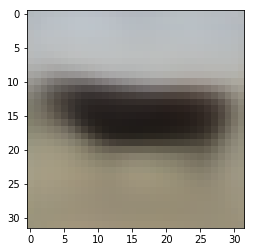

/home/voithru/anaconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voithru/anaconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voithru/anaconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[Training Epoch: 0 	n_iter: 50 	Loss: 116875.335938]


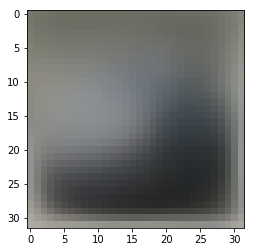

[Training Epoch: 0 	n_iter: 100 	Loss: 113887.507812]


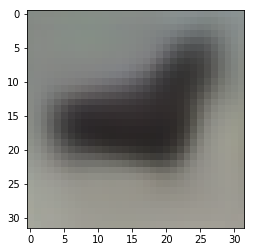

[Training Epoch: 0 	n_iter: 150 	Loss: 116456.578125]


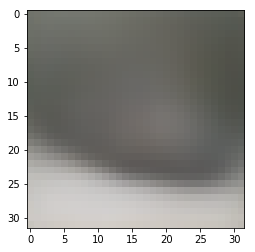

[Training Epoch: 0 	n_iter: 200 	Loss: 118214.382812]


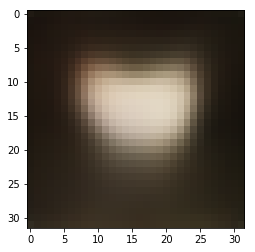

[Training Epoch: 0 	n_iter: 250 	Loss: 118613.054688]


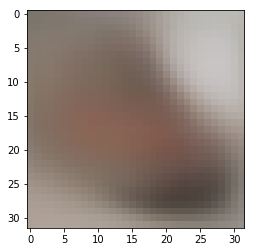

[Training Epoch: 0 	n_iter: 300 	Loss: 117029.843750]


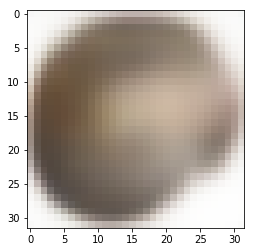

[Training Epoch: 0 	n_iter: 350 	Loss: 118552.250000]


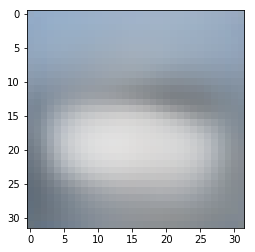

[Training Epoch: 0 	n_iter: 400 	Loss: 118727.335938]


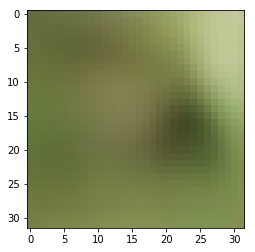

[Training Epoch: 0 	n_iter: 450 	Loss: 120213.484375]


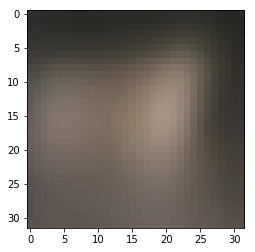

[Training Epoch: 0 	n_iter: 500 	Loss: 118974.703125]


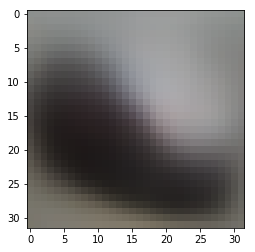

[Training Epoch: 0 	n_iter: 550 	Loss: 116001.335938]


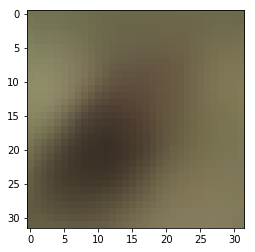

[Training Epoch: 0 	n_iter: 600 	Loss: 116077.062500]


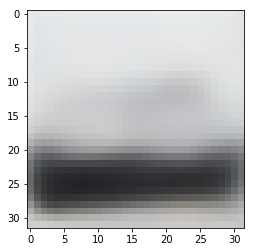

[Training Epoch: 0 	n_iter: 650 	Loss: 115291.601562]


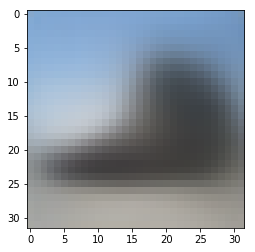

[Training Epoch: 0 	n_iter: 700 	Loss: 115211.562500]


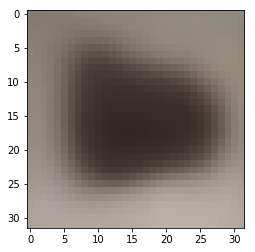

[Training Epoch: 0 	n_iter: 750 	Loss: 119491.085938]


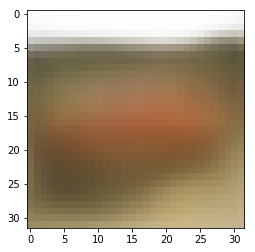

[Training Epoch: 1 	n_iter: 781 	Loss: 118394.914062]


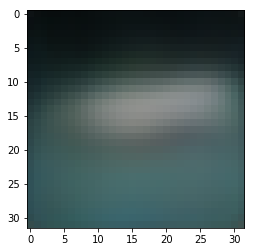

[Training Epoch: 1 	n_iter: 831 	Loss: 115756.406250]


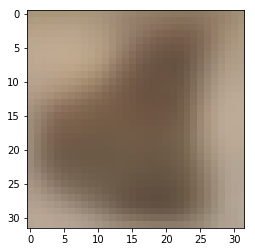

[Training Epoch: 1 	n_iter: 881 	Loss: 116817.273438]


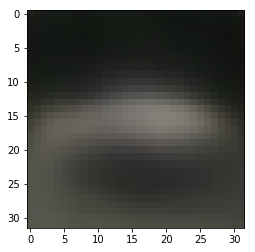

[Training Epoch: 1 	n_iter: 931 	Loss: 118861.257812]


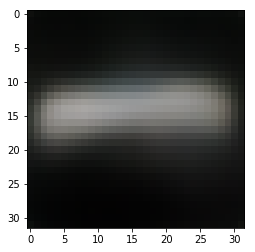

[Training Epoch: 1 	n_iter: 981 	Loss: 117221.734375]


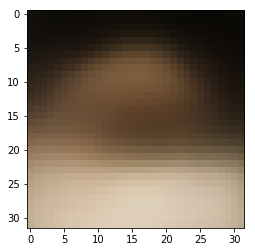

[Training Epoch: 1 	n_iter: 1031 	Loss: 120352.750000]


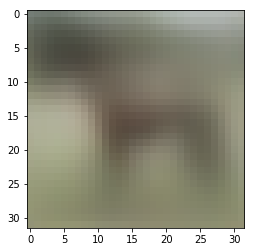

[Training Epoch: 1 	n_iter: 1081 	Loss: 116482.875000]


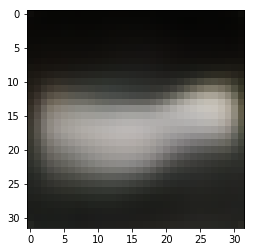

[Training Epoch: 1 	n_iter: 1131 	Loss: 119259.156250]


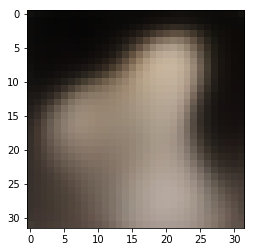

[Training Epoch: 1 	n_iter: 1181 	Loss: 117353.914062]


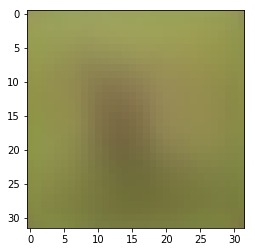

[Training Epoch: 1 	n_iter: 1231 	Loss: 116690.335938]


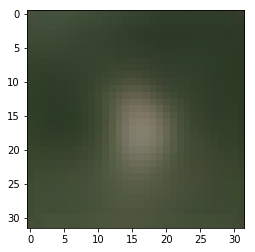

[Training Epoch: 1 	n_iter: 1281 	Loss: 121505.890625]


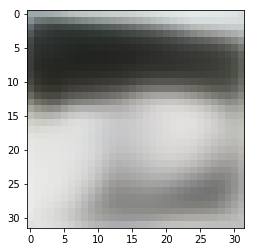

[Training Epoch: 1 	n_iter: 1331 	Loss: 115331.968750]


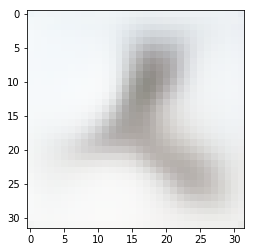

[Training Epoch: 1 	n_iter: 1381 	Loss: 117151.945312]


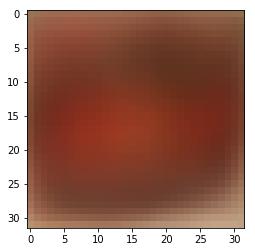

[Training Epoch: 1 	n_iter: 1431 	Loss: 115827.273438]


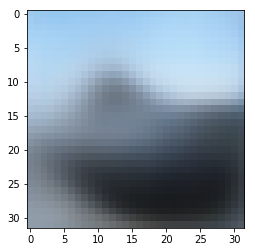

[Training Epoch: 1 	n_iter: 1481 	Loss: 118635.125000]


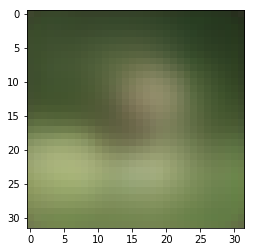

[Training Epoch: 1 	n_iter: 1531 	Loss: 119304.429688]


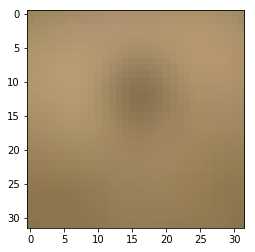

[Training Epoch: 2 	n_iter: 1562 	Loss: 118778.445312]


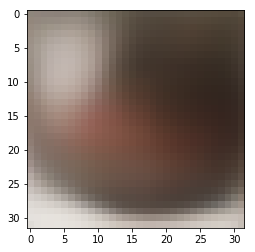

[Training Epoch: 2 	n_iter: 1612 	Loss: 119665.171875]


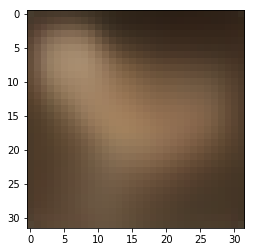

[Training Epoch: 2 	n_iter: 1662 	Loss: 122069.101562]


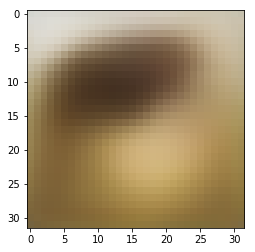

[Training Epoch: 2 	n_iter: 1712 	Loss: 117621.710938]


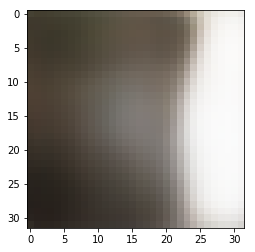

[Training Epoch: 2 	n_iter: 1762 	Loss: 115941.140625]


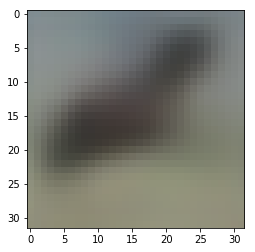

[Training Epoch: 2 	n_iter: 1812 	Loss: 119042.953125]


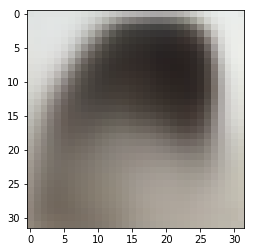

[Training Epoch: 2 	n_iter: 1862 	Loss: 118819.148438]


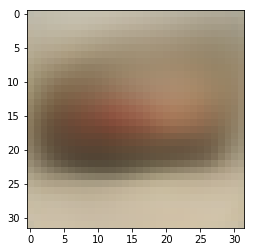

[Training Epoch: 2 	n_iter: 1912 	Loss: 115999.437500]


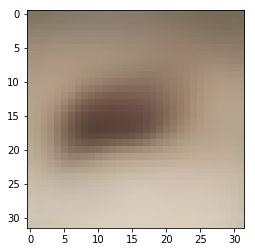

[Training Epoch: 2 	n_iter: 1962 	Loss: 117698.062500]


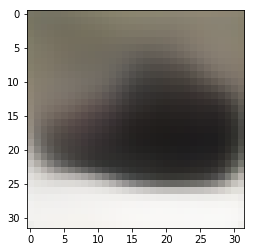

[Training Epoch: 2 	n_iter: 2012 	Loss: 118382.890625]


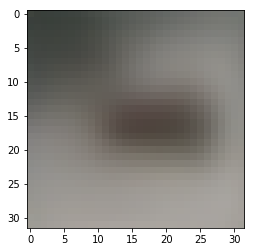

[Training Epoch: 2 	n_iter: 2062 	Loss: 116443.851562]


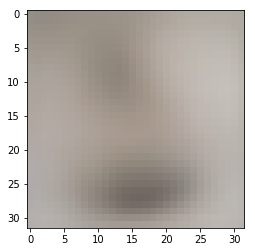

[Training Epoch: 2 	n_iter: 2112 	Loss: 120731.390625]


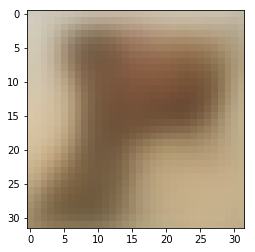

[Training Epoch: 2 	n_iter: 2162 	Loss: 117759.890625]


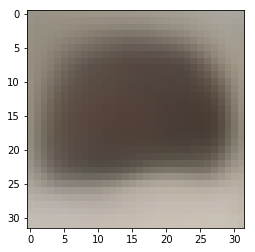

[Training Epoch: 2 	n_iter: 2212 	Loss: 118266.710938]


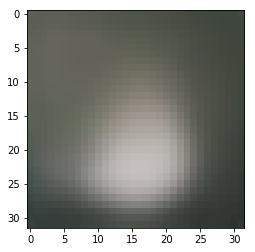

[Training Epoch: 2 	n_iter: 2262 	Loss: 117490.984375]


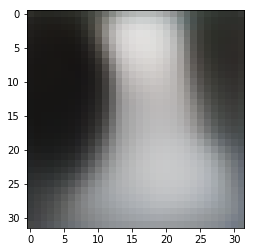

[Training Epoch: 2 	n_iter: 2312 	Loss: 119265.828125]


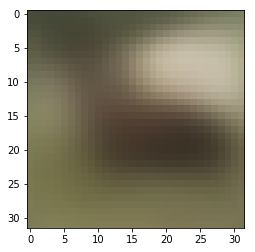

[Training Epoch: 3 	n_iter: 2343 	Loss: 117897.671875]


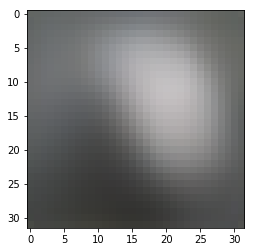

[Training Epoch: 3 	n_iter: 2393 	Loss: 117034.656250]


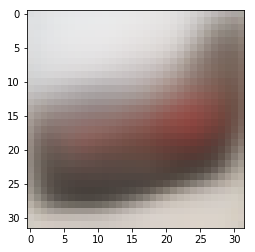

[Training Epoch: 3 	n_iter: 2443 	Loss: 117776.898438]


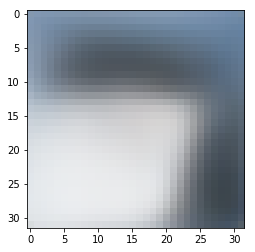

[Training Epoch: 3 	n_iter: 2493 	Loss: 123088.304688]


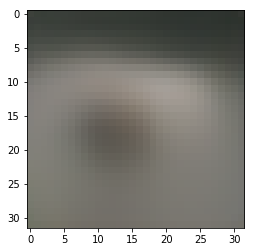

[Training Epoch: 3 	n_iter: 2543 	Loss: 116536.906250]


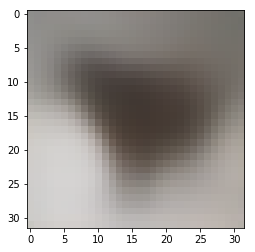

[Training Epoch: 3 	n_iter: 2593 	Loss: 115329.773438]


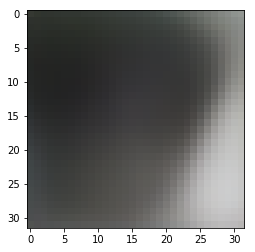

[Training Epoch: 3 	n_iter: 2643 	Loss: 114572.781250]


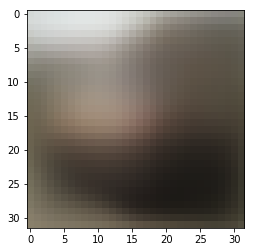

[Training Epoch: 3 	n_iter: 2693 	Loss: 116980.687500]


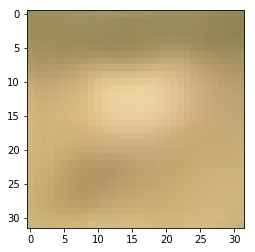

[Training Epoch: 3 	n_iter: 2743 	Loss: 114199.117188]


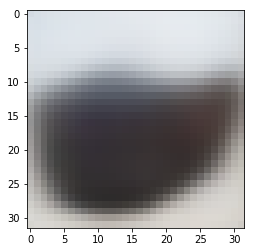

[Training Epoch: 3 	n_iter: 2793 	Loss: 118254.882812]


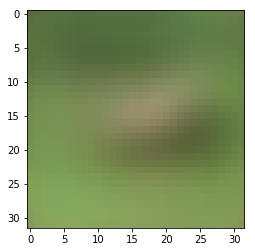

[Training Epoch: 3 	n_iter: 2843 	Loss: 115055.539062]


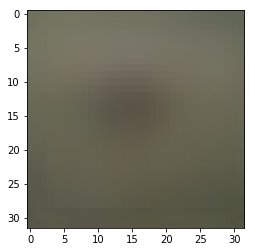

[Training Epoch: 3 	n_iter: 2893 	Loss: 116154.257812]


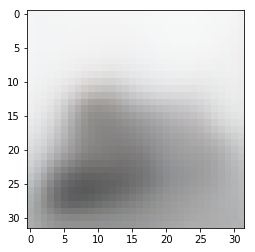

[Training Epoch: 3 	n_iter: 2943 	Loss: 122201.882812]


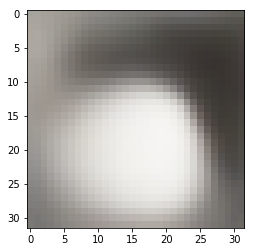

[Training Epoch: 3 	n_iter: 2993 	Loss: 122213.843750]


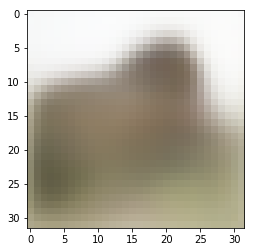

[Training Epoch: 3 	n_iter: 3043 	Loss: 118720.250000]


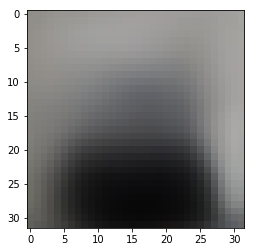

[Training Epoch: 3 	n_iter: 3093 	Loss: 116624.273438]


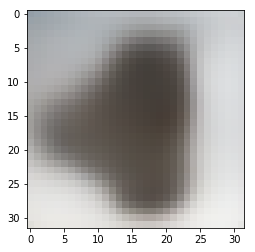

[Training Epoch: 4 	n_iter: 3124 	Loss: 120398.234375]


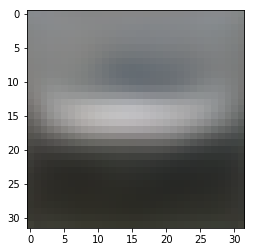

[Training Epoch: 4 	n_iter: 3174 	Loss: 116172.507812]


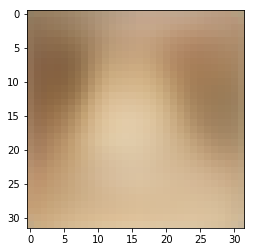

[Training Epoch: 4 	n_iter: 3224 	Loss: 117223.109375]


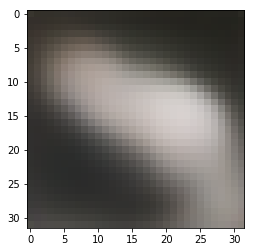

[Training Epoch: 4 	n_iter: 3274 	Loss: 118662.718750]


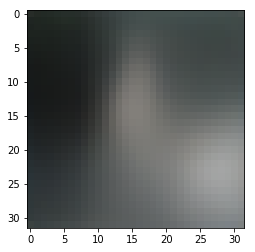

[Training Epoch: 4 	n_iter: 3324 	Loss: 117686.796875]


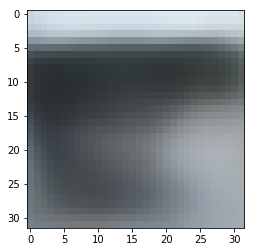

[Training Epoch: 4 	n_iter: 3374 	Loss: 119172.070312]


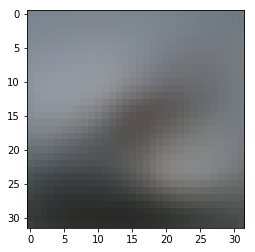

[Training Epoch: 4 	n_iter: 3424 	Loss: 120184.507812]


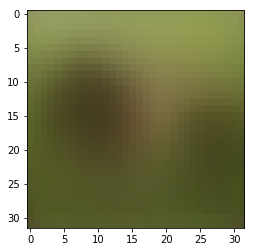

[Training Epoch: 4 	n_iter: 3474 	Loss: 118813.476562]


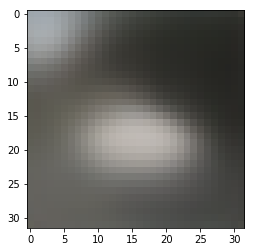

[Training Epoch: 4 	n_iter: 3524 	Loss: 118164.929688]


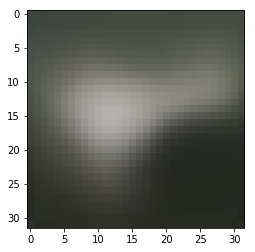

[Training Epoch: 4 	n_iter: 3574 	Loss: 116250.632812]


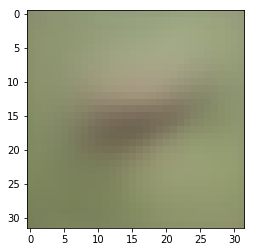

[Training Epoch: 4 	n_iter: 3624 	Loss: 119673.421875]


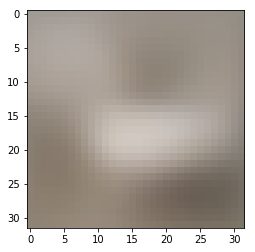

[Training Epoch: 4 	n_iter: 3674 	Loss: 116354.414062]


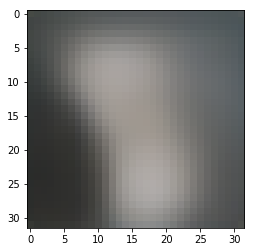

[Training Epoch: 4 	n_iter: 3724 	Loss: 118299.187500]


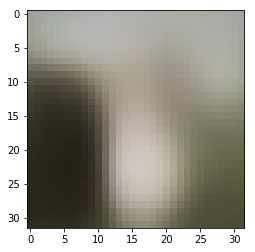

[Training Epoch: 4 	n_iter: 3774 	Loss: 117365.632812]


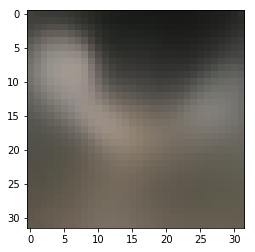

[Training Epoch: 4 	n_iter: 3824 	Loss: 117388.890625]


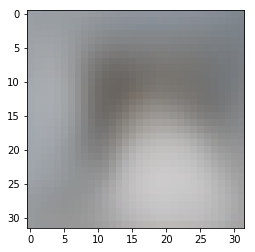

[Training Epoch: 4 	n_iter: 3874 	Loss: 118014.039062]


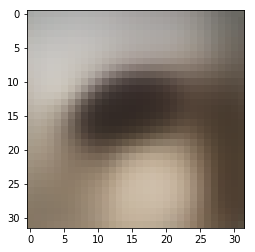

[Training Epoch: 5 	n_iter: 3905 	Loss: 117870.929688]


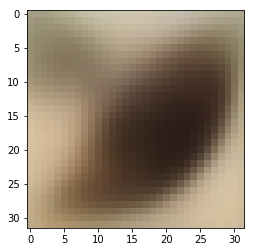

[Training Epoch: 5 	n_iter: 3955 	Loss: 120341.460938]


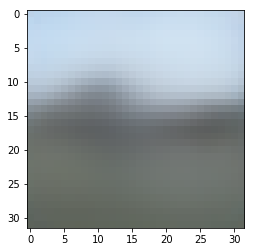

[Training Epoch: 5 	n_iter: 4005 	Loss: 116287.960938]


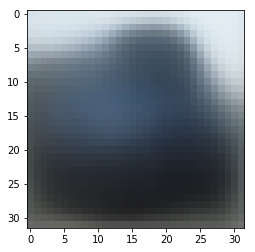

[Training Epoch: 5 	n_iter: 4055 	Loss: 118927.085938]


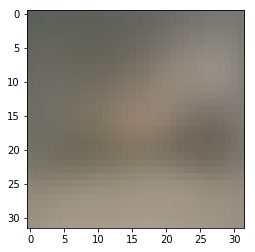

[Training Epoch: 5 	n_iter: 4105 	Loss: 120983.000000]


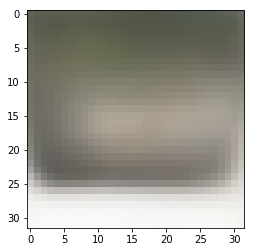

[Training Epoch: 5 	n_iter: 4155 	Loss: 117177.093750]


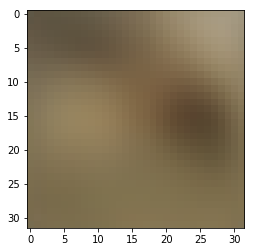

[Training Epoch: 5 	n_iter: 4205 	Loss: 118568.953125]


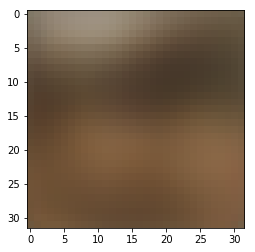

[Training Epoch: 5 	n_iter: 4255 	Loss: 119631.484375]


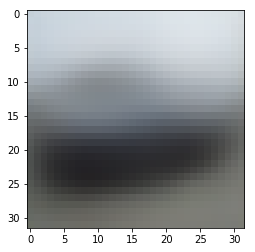

[Training Epoch: 5 	n_iter: 4305 	Loss: 116555.742188]


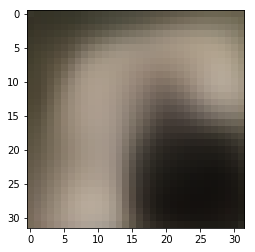

[Training Epoch: 5 	n_iter: 4355 	Loss: 119832.562500]


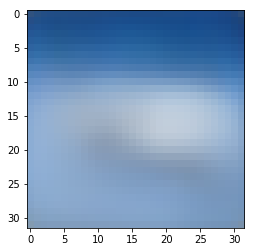

[Training Epoch: 5 	n_iter: 4405 	Loss: 114515.531250]


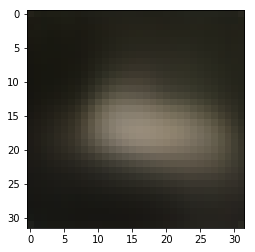

[Training Epoch: 5 	n_iter: 4455 	Loss: 118103.382812]


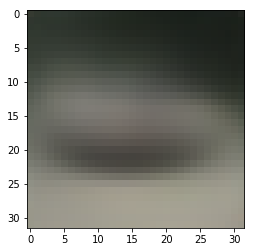

[Training Epoch: 5 	n_iter: 4505 	Loss: 119147.945312]


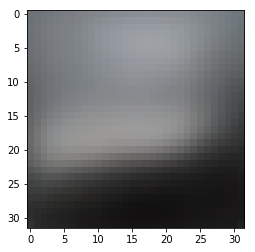

[Training Epoch: 5 	n_iter: 4555 	Loss: 117576.062500]


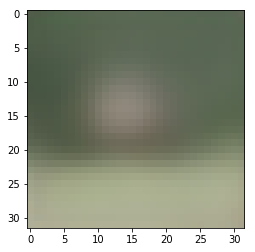

[Training Epoch: 5 	n_iter: 4605 	Loss: 115330.890625]


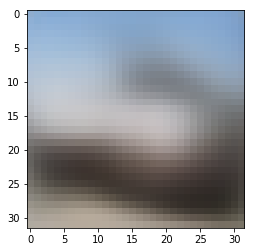

[Training Epoch: 5 	n_iter: 4655 	Loss: 117171.812500]


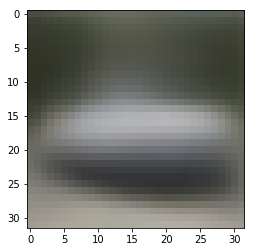

[Training Epoch: 6 	n_iter: 4686 	Loss: 119685.117188]


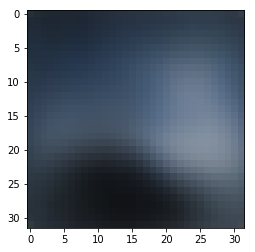

[Training Epoch: 6 	n_iter: 4736 	Loss: 119958.328125]


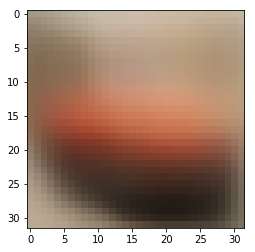

[Training Epoch: 6 	n_iter: 4786 	Loss: 116469.500000]


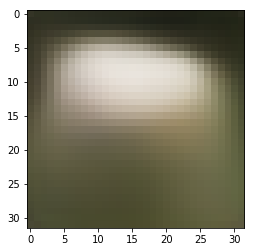

[Training Epoch: 6 	n_iter: 4836 	Loss: 119024.062500]


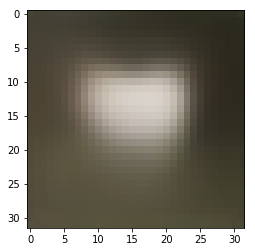

[Training Epoch: 6 	n_iter: 4886 	Loss: 117608.437500]


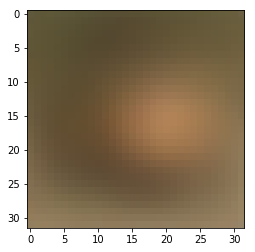

[Training Epoch: 6 	n_iter: 4936 	Loss: 117199.046875]


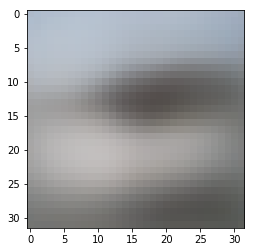

[Training Epoch: 6 	n_iter: 4986 	Loss: 117621.554688]


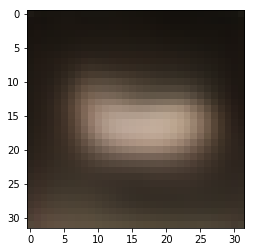

[Training Epoch: 6 	n_iter: 5036 	Loss: 117740.453125]


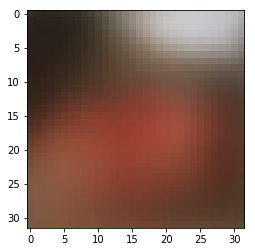

[Training Epoch: 6 	n_iter: 5086 	Loss: 117503.359375]


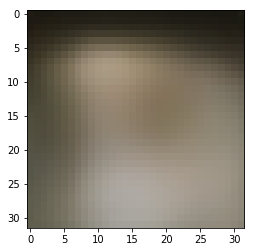

[Training Epoch: 6 	n_iter: 5136 	Loss: 118834.742188]


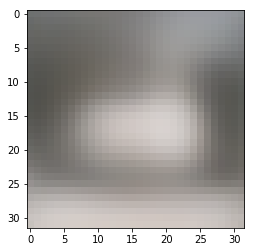

[Training Epoch: 6 	n_iter: 5186 	Loss: 117671.718750]


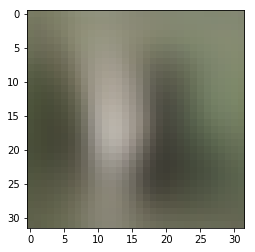

[Training Epoch: 6 	n_iter: 5236 	Loss: 119614.125000]


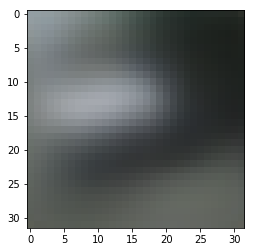

[Training Epoch: 6 	n_iter: 5286 	Loss: 118446.453125]


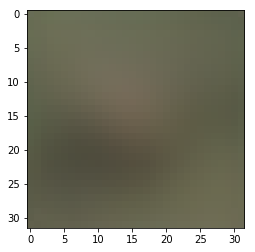

[Training Epoch: 6 	n_iter: 5336 	Loss: 116423.453125]


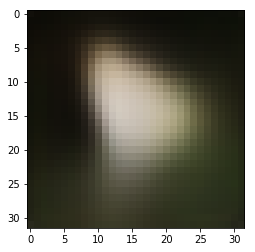

[Training Epoch: 6 	n_iter: 5386 	Loss: 116022.398438]


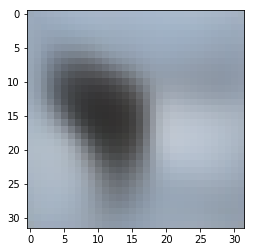

[Training Epoch: 6 	n_iter: 5436 	Loss: 113845.726562]


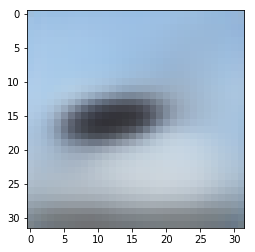

[Training Epoch: 7 	n_iter: 5467 	Loss: 118078.156250]


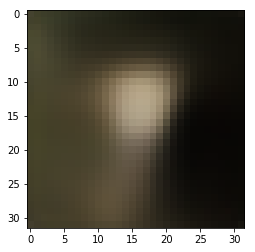

[Training Epoch: 7 	n_iter: 5517 	Loss: 118063.414062]


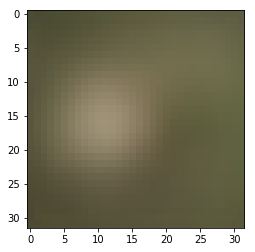

[Training Epoch: 7 	n_iter: 5567 	Loss: 117103.648438]


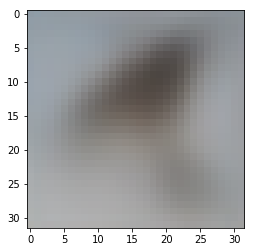

[Training Epoch: 7 	n_iter: 5617 	Loss: 117498.968750]


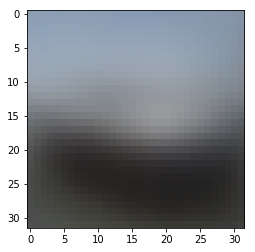

[Training Epoch: 7 	n_iter: 5667 	Loss: 118864.460938]


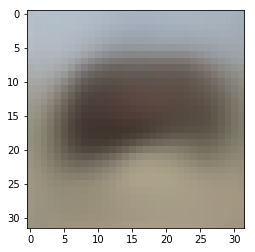

[Training Epoch: 7 	n_iter: 5717 	Loss: 118101.750000]


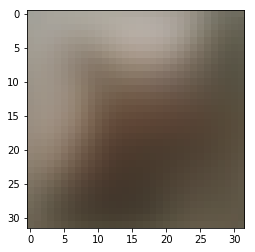

[Training Epoch: 7 	n_iter: 5767 	Loss: 117027.289062]


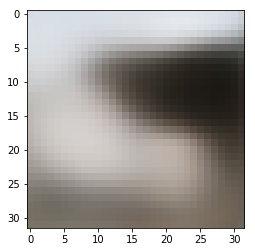

[Training Epoch: 7 	n_iter: 5817 	Loss: 115940.898438]


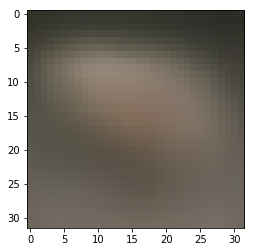

[Training Epoch: 7 	n_iter: 5867 	Loss: 117323.203125]


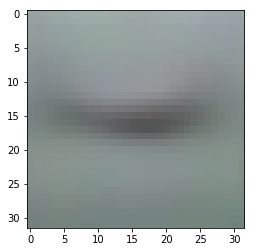

[Training Epoch: 7 	n_iter: 5917 	Loss: 119600.820312]


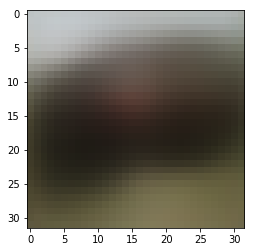

[Training Epoch: 7 	n_iter: 5967 	Loss: 116139.890625]


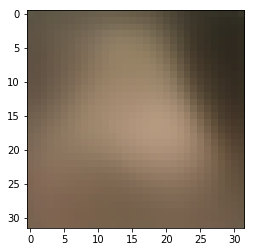

[Training Epoch: 7 	n_iter: 6017 	Loss: 117675.031250]


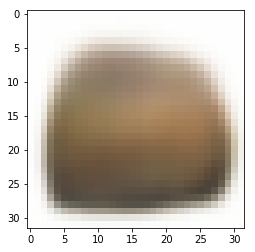

[Training Epoch: 7 	n_iter: 6067 	Loss: 117965.640625]


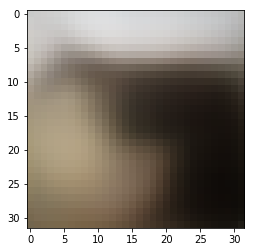

[Training Epoch: 7 	n_iter: 6117 	Loss: 115768.570312]


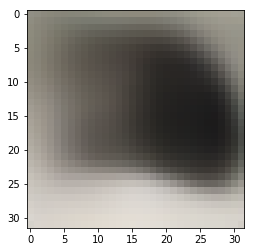

[Training Epoch: 7 	n_iter: 6167 	Loss: 120668.554688]


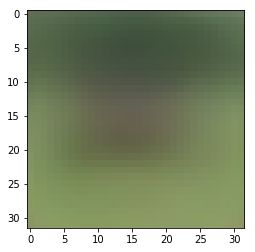

[Training Epoch: 7 	n_iter: 6217 	Loss: 115896.460938]


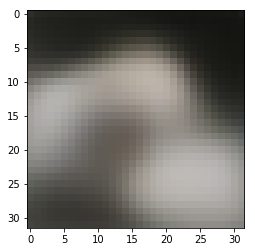

[Training Epoch: 8 	n_iter: 6248 	Loss: 118436.539062]


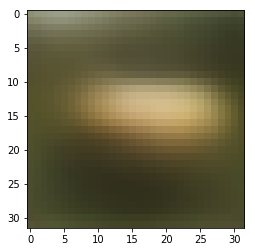

[Training Epoch: 8 	n_iter: 6298 	Loss: 115156.757812]


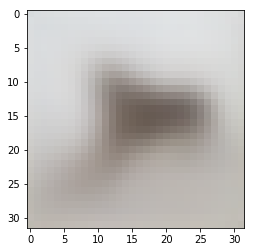

[Training Epoch: 8 	n_iter: 6348 	Loss: 120181.351562]


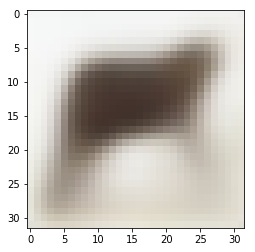

[Training Epoch: 8 	n_iter: 6398 	Loss: 120363.937500]


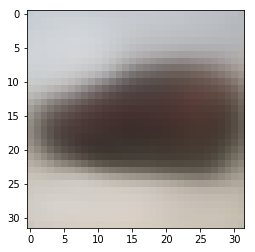

[Training Epoch: 8 	n_iter: 6448 	Loss: 116098.210938]


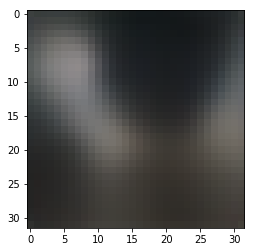

[Training Epoch: 8 	n_iter: 6498 	Loss: 118491.539062]


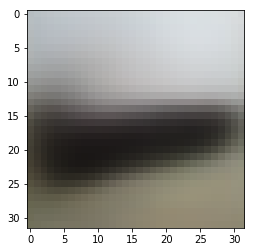

[Training Epoch: 8 	n_iter: 6548 	Loss: 117232.859375]


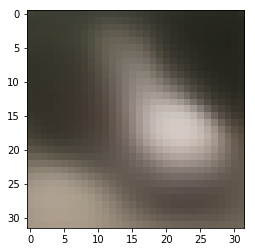

[Training Epoch: 8 	n_iter: 6598 	Loss: 118548.226562]


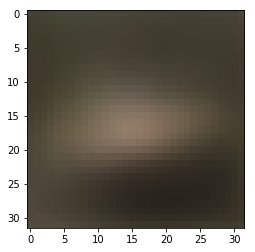

[Training Epoch: 8 	n_iter: 6648 	Loss: 118926.101562]


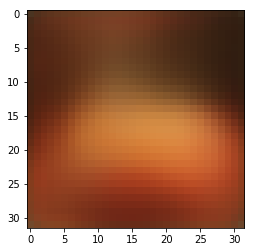

[Training Epoch: 8 	n_iter: 6698 	Loss: 117770.312500]


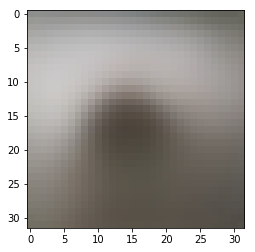

[Training Epoch: 8 	n_iter: 6748 	Loss: 117718.210938]


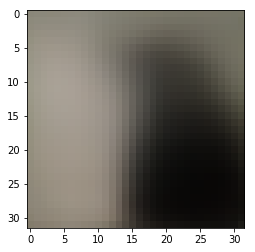

[Training Epoch: 8 	n_iter: 6798 	Loss: 119616.562500]


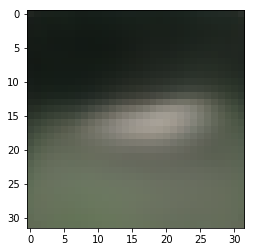

[Training Epoch: 8 	n_iter: 6848 	Loss: 117929.742188]


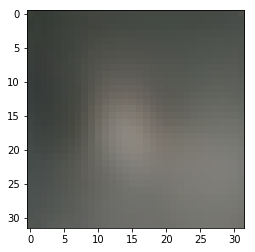

[Training Epoch: 8 	n_iter: 6898 	Loss: 118085.523438]


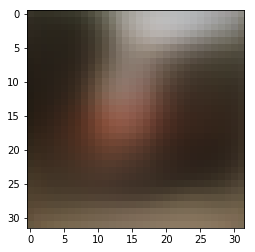

[Training Epoch: 8 	n_iter: 6948 	Loss: 119603.085938]


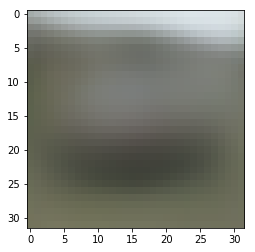

[Training Epoch: 8 	n_iter: 6998 	Loss: 120360.945312]


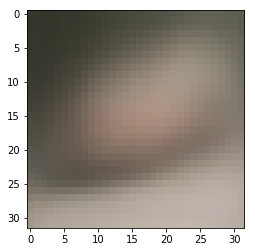

[Training Epoch: 9 	n_iter: 7029 	Loss: 118427.070312]


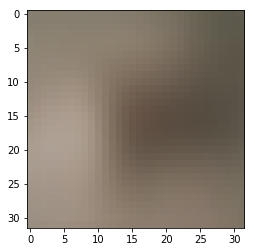

[Training Epoch: 9 	n_iter: 7079 	Loss: 119887.437500]


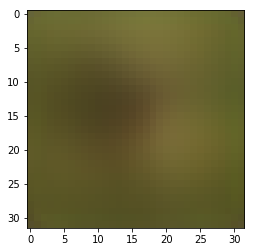

[Training Epoch: 9 	n_iter: 7129 	Loss: 115455.750000]


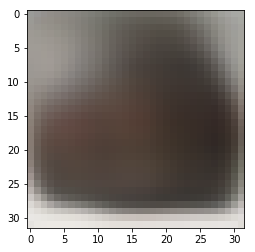

[Training Epoch: 9 	n_iter: 7179 	Loss: 119054.492188]


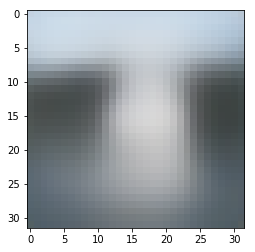

[Training Epoch: 9 	n_iter: 7229 	Loss: 120068.835938]


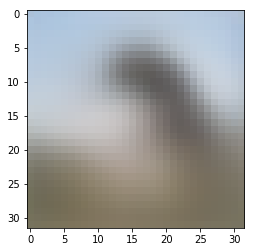

[Training Epoch: 9 	n_iter: 7279 	Loss: 119347.070312]


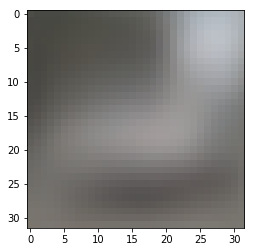

[Training Epoch: 9 	n_iter: 7329 	Loss: 114899.265625]


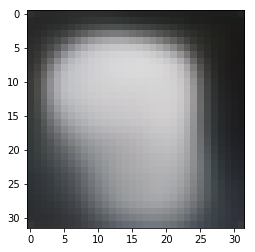

[Training Epoch: 9 	n_iter: 7379 	Loss: 118105.789062]


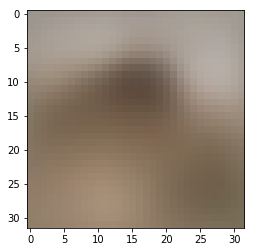

[Training Epoch: 9 	n_iter: 7429 	Loss: 118224.914062]


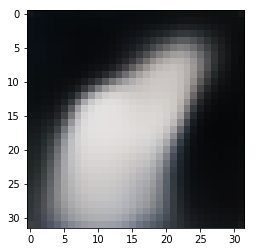

[Training Epoch: 9 	n_iter: 7479 	Loss: 117959.101562]


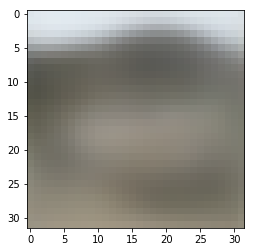

[Training Epoch: 9 	n_iter: 7529 	Loss: 114544.367188]


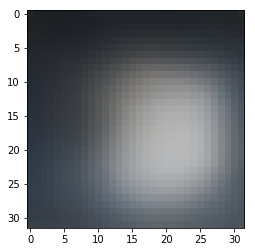

[Training Epoch: 9 	n_iter: 7579 	Loss: 116818.562500]


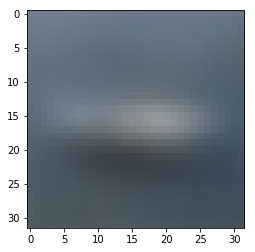

[Training Epoch: 9 	n_iter: 7629 	Loss: 120357.906250]


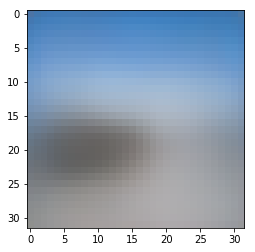

[Training Epoch: 9 	n_iter: 7679 	Loss: 115433.992188]


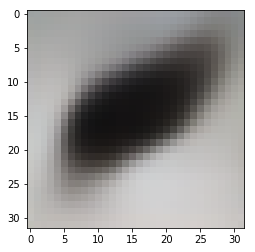

[Training Epoch: 9 	n_iter: 7729 	Loss: 116358.281250]


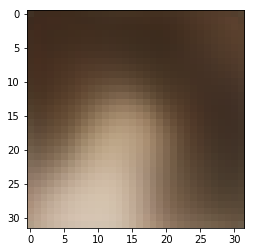

[Training Epoch: 9 	n_iter: 7779 	Loss: 119477.609375]


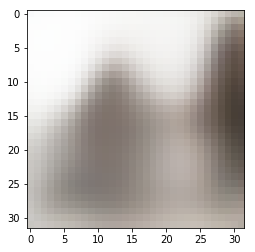

[Training Epoch: 10 	n_iter: 7810 	Loss: 119815.109375]


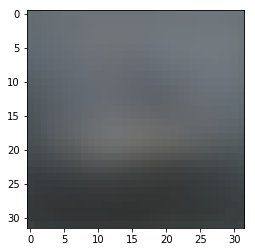

[Training Epoch: 10 	n_iter: 7860 	Loss: 116877.593750]


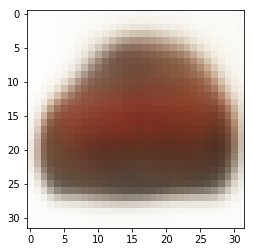

[Training Epoch: 10 	n_iter: 7910 	Loss: 120946.585938]


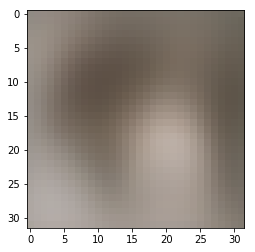

[Training Epoch: 10 	n_iter: 7960 	Loss: 116179.593750]


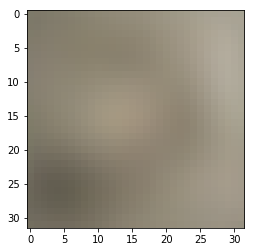

[Training Epoch: 10 	n_iter: 8010 	Loss: 119012.078125]


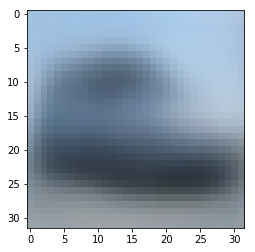

[Training Epoch: 10 	n_iter: 8060 	Loss: 119626.320312]


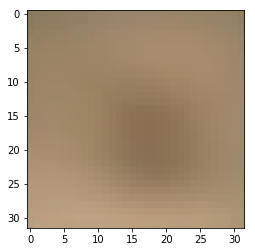

[Training Epoch: 10 	n_iter: 8110 	Loss: 118598.320312]


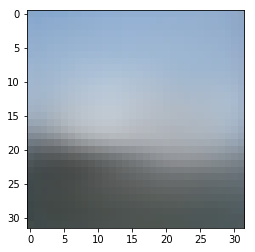

[Training Epoch: 10 	n_iter: 8160 	Loss: 120595.265625]


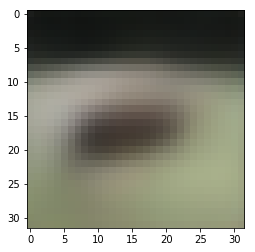

[Training Epoch: 10 	n_iter: 8210 	Loss: 119629.000000]


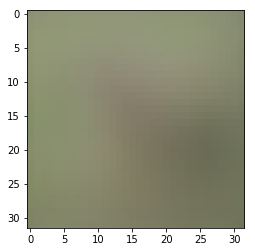

[Training Epoch: 10 	n_iter: 8260 	Loss: 118434.007812]


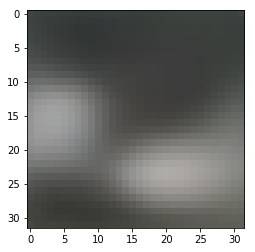

[Training Epoch: 10 	n_iter: 8310 	Loss: 117142.101562]


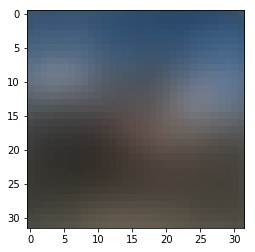

[Training Epoch: 10 	n_iter: 8360 	Loss: 112359.468750]


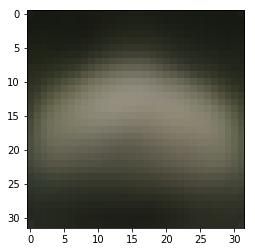

[Training Epoch: 10 	n_iter: 8410 	Loss: 122060.781250]


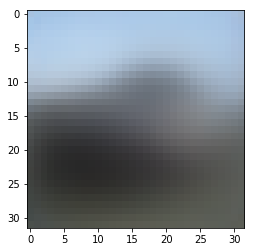

[Training Epoch: 10 	n_iter: 8460 	Loss: 118756.304688]


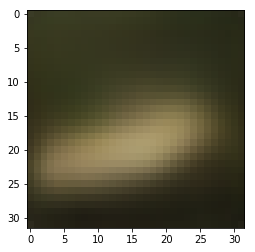

[Training Epoch: 10 	n_iter: 8510 	Loss: 118074.460938]


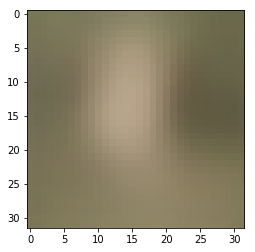

[Training Epoch: 10 	n_iter: 8560 	Loss: 116871.726562]


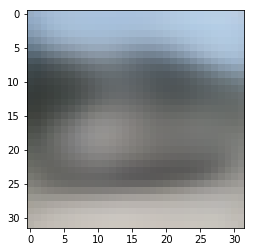

[Training Epoch: 11 	n_iter: 8591 	Loss: 115953.531250]


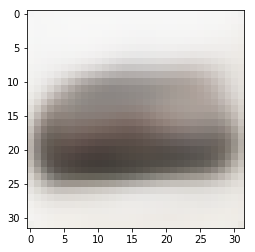

[Training Epoch: 11 	n_iter: 8641 	Loss: 114820.679688]


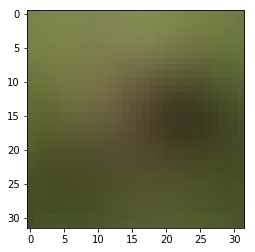

[Training Epoch: 11 	n_iter: 8691 	Loss: 118599.734375]


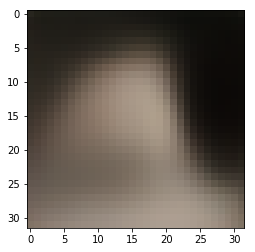

[Training Epoch: 11 	n_iter: 8741 	Loss: 117802.351562]


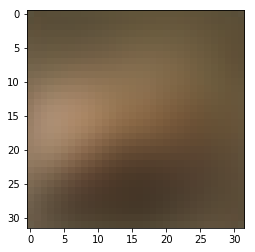

[Training Epoch: 11 	n_iter: 8791 	Loss: 117740.906250]


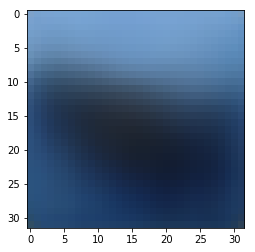

[Training Epoch: 11 	n_iter: 8841 	Loss: 117382.593750]


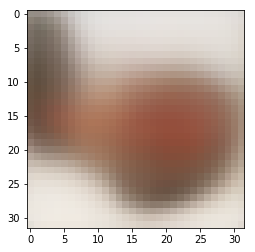

[Training Epoch: 11 	n_iter: 8891 	Loss: 119861.765625]


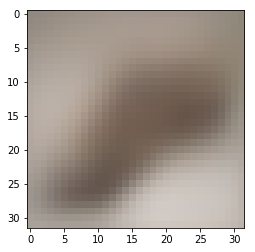

[Training Epoch: 11 	n_iter: 8941 	Loss: 115025.023438]


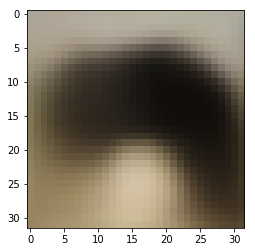

[Training Epoch: 11 	n_iter: 8991 	Loss: 119108.000000]


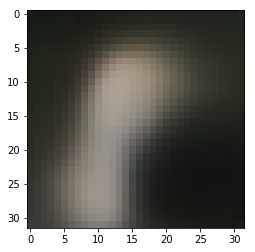

[Training Epoch: 11 	n_iter: 9041 	Loss: 116961.773438]


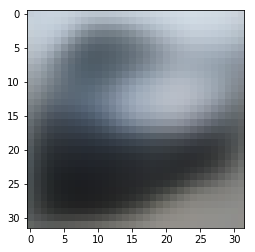

[Training Epoch: 11 	n_iter: 9091 	Loss: 118761.984375]


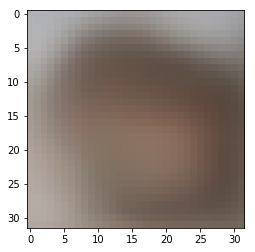

[Training Epoch: 11 	n_iter: 9141 	Loss: 119682.218750]


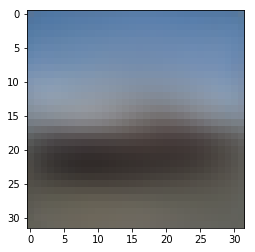

[Training Epoch: 11 	n_iter: 9191 	Loss: 117987.382812]


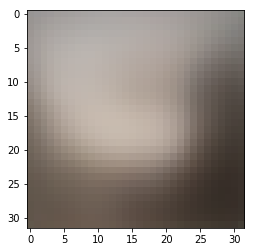

[Training Epoch: 11 	n_iter: 9241 	Loss: 116922.164062]


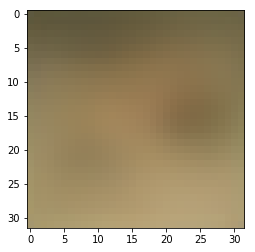

[Training Epoch: 11 	n_iter: 9291 	Loss: 117593.234375]


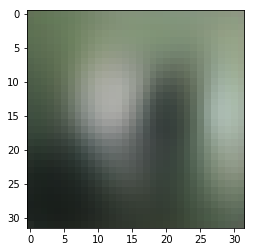

[Training Epoch: 11 	n_iter: 9341 	Loss: 119139.359375]


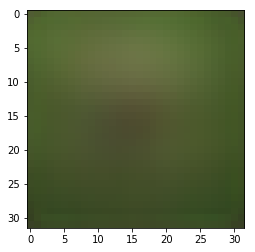

[Training Epoch: 12 	n_iter: 9372 	Loss: 117783.812500]


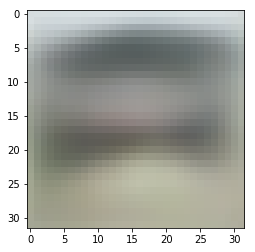

[Training Epoch: 12 	n_iter: 9422 	Loss: 115299.156250]


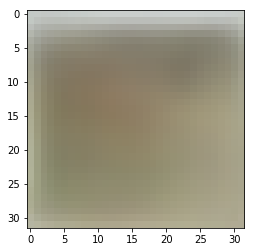

[Training Epoch: 12 	n_iter: 9472 	Loss: 117802.250000]


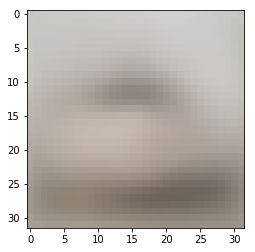

[Training Epoch: 12 	n_iter: 9522 	Loss: 118726.718750]


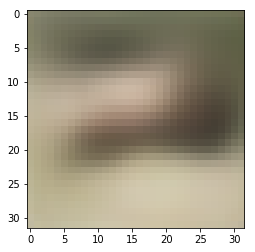

[Training Epoch: 12 	n_iter: 9572 	Loss: 116376.992188]


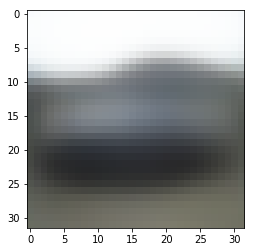

[Training Epoch: 12 	n_iter: 9622 	Loss: 115035.835938]


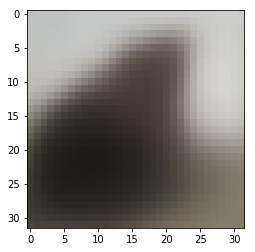

[Training Epoch: 12 	n_iter: 9672 	Loss: 118975.703125]


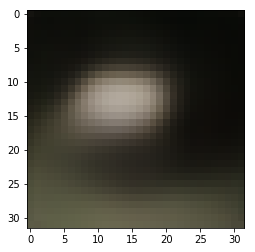

[Training Epoch: 12 	n_iter: 9722 	Loss: 121057.664062]


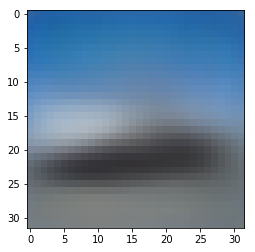

[Training Epoch: 12 	n_iter: 9772 	Loss: 118902.179688]


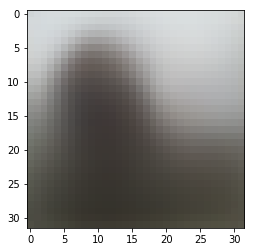

[Training Epoch: 12 	n_iter: 9822 	Loss: 118740.367188]


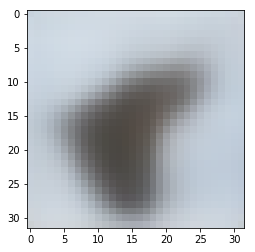

[Training Epoch: 12 	n_iter: 9872 	Loss: 118717.500000]


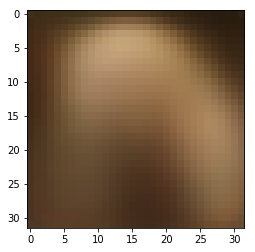

[Training Epoch: 12 	n_iter: 9922 	Loss: 119149.210938]


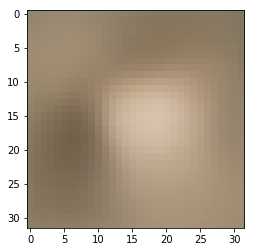

[Training Epoch: 12 	n_iter: 9972 	Loss: 119005.609375]


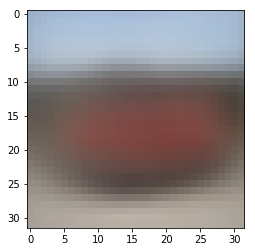

[Training Epoch: 12 	n_iter: 10022 	Loss: 120965.921875]


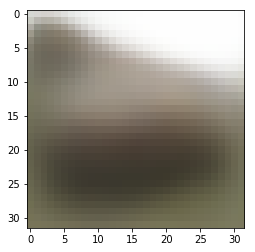

[Training Epoch: 12 	n_iter: 10072 	Loss: 117023.609375]


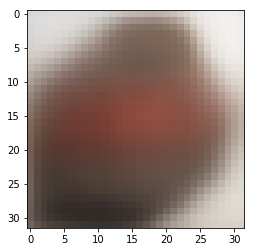

[Training Epoch: 12 	n_iter: 10122 	Loss: 115188.070312]


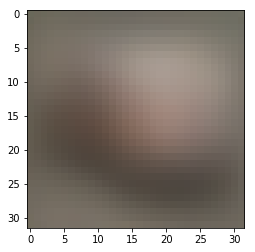

[Training Epoch: 13 	n_iter: 10153 	Loss: 117860.820312]


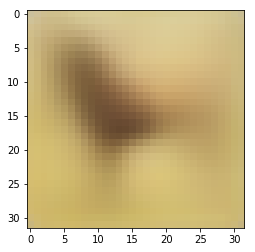

[Training Epoch: 13 	n_iter: 10203 	Loss: 117110.640625]


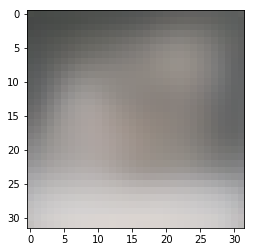

[Training Epoch: 13 	n_iter: 10253 	Loss: 118931.898438]


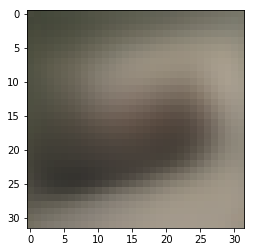

[Training Epoch: 13 	n_iter: 10303 	Loss: 118656.500000]


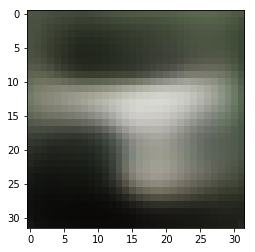

[Training Epoch: 13 	n_iter: 10353 	Loss: 116155.445312]


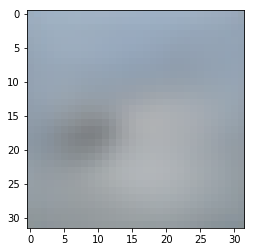

[Training Epoch: 13 	n_iter: 10403 	Loss: 118003.546875]


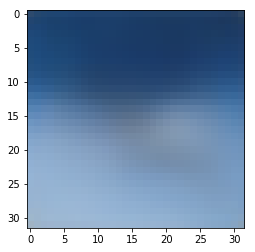

[Training Epoch: 13 	n_iter: 10453 	Loss: 119590.828125]


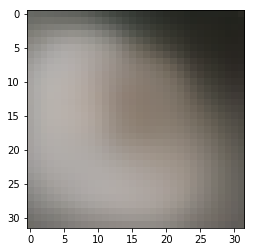

[Training Epoch: 13 	n_iter: 10503 	Loss: 119962.726562]


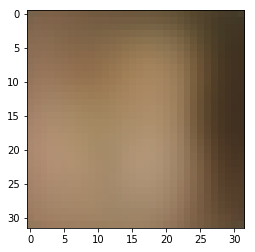

[Training Epoch: 13 	n_iter: 10553 	Loss: 118223.335938]


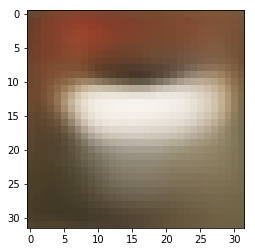

[Training Epoch: 13 	n_iter: 10603 	Loss: 118693.507812]


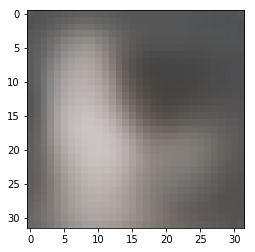

[Training Epoch: 13 	n_iter: 10653 	Loss: 118125.875000]


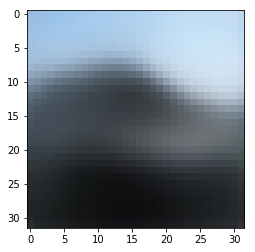

[Training Epoch: 13 	n_iter: 10703 	Loss: 115763.210938]


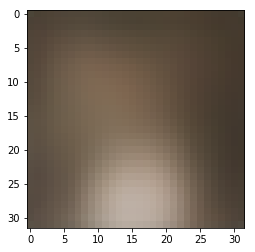

[Training Epoch: 13 	n_iter: 10753 	Loss: 119693.101562]


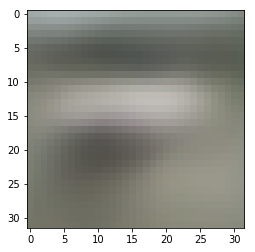

[Training Epoch: 13 	n_iter: 10803 	Loss: 120102.117188]


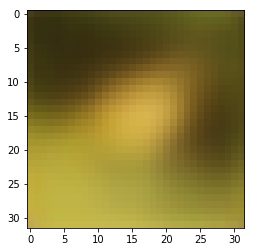

[Training Epoch: 13 	n_iter: 10853 	Loss: 116642.164062]


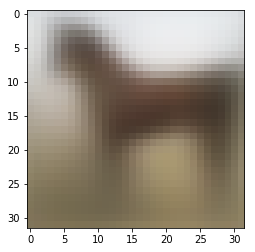

[Training Epoch: 13 	n_iter: 10903 	Loss: 115619.757812]


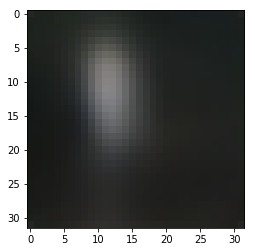

[Training Epoch: 14 	n_iter: 10934 	Loss: 116417.968750]


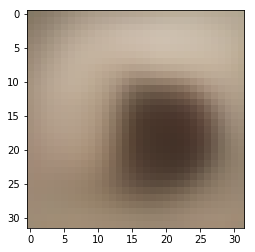

[Training Epoch: 14 	n_iter: 10984 	Loss: 121522.585938]


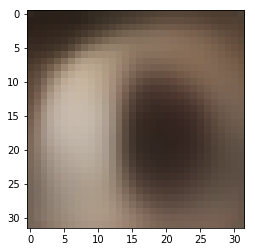

[Training Epoch: 14 	n_iter: 11034 	Loss: 117107.648438]


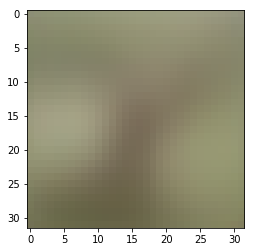

[Training Epoch: 14 	n_iter: 11084 	Loss: 119132.437500]


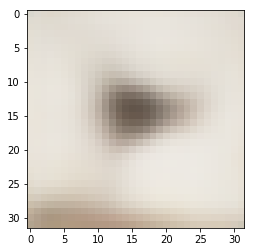

[Training Epoch: 14 	n_iter: 11134 	Loss: 119613.476562]


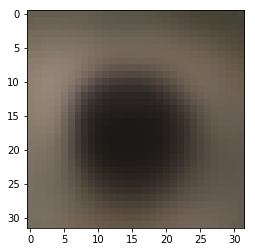

[Training Epoch: 14 	n_iter: 11184 	Loss: 120039.007812]


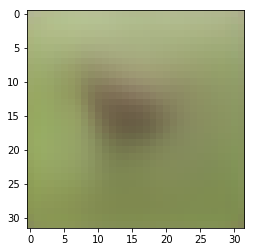

[Training Epoch: 14 	n_iter: 11234 	Loss: 114109.687500]


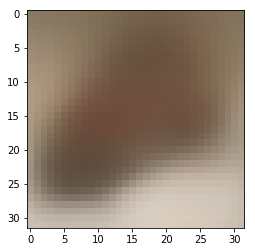

[Training Epoch: 14 	n_iter: 11284 	Loss: 117503.398438]


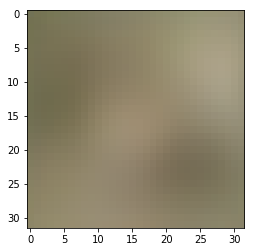

[Training Epoch: 14 	n_iter: 11334 	Loss: 117487.765625]


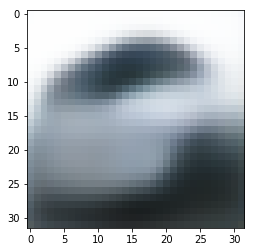

[Training Epoch: 14 	n_iter: 11384 	Loss: 118859.828125]


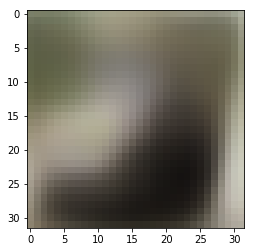

[Training Epoch: 14 	n_iter: 11434 	Loss: 117606.695312]


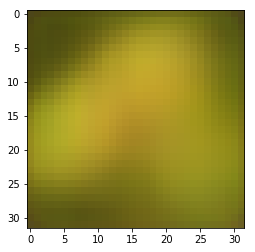

[Training Epoch: 14 	n_iter: 11484 	Loss: 118723.085938]


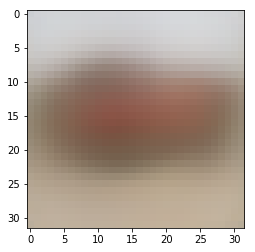

[Training Epoch: 14 	n_iter: 11534 	Loss: 120237.453125]


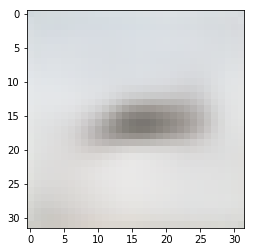

[Training Epoch: 14 	n_iter: 11584 	Loss: 118330.882812]


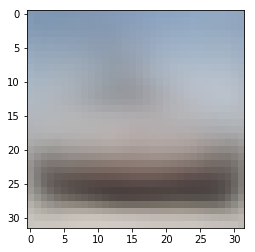

[Training Epoch: 14 	n_iter: 11634 	Loss: 118934.789062]


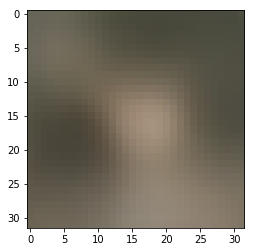

[Training Epoch: 14 	n_iter: 11684 	Loss: 118714.726562]


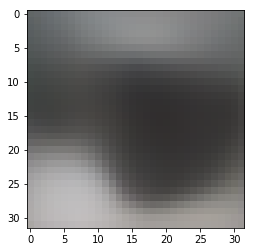

[Training Epoch: 15 	n_iter: 11715 	Loss: 118982.289062]


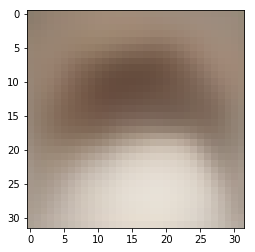

[Training Epoch: 15 	n_iter: 11765 	Loss: 115624.953125]


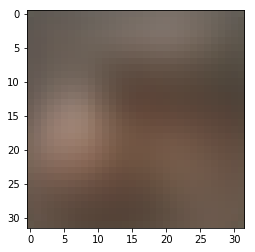

[Training Epoch: 15 	n_iter: 11815 	Loss: 117296.226562]


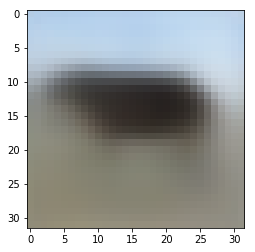

[Training Epoch: 15 	n_iter: 11865 	Loss: 116576.812500]


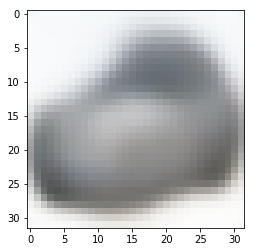

[Training Epoch: 15 	n_iter: 11915 	Loss: 119640.320312]


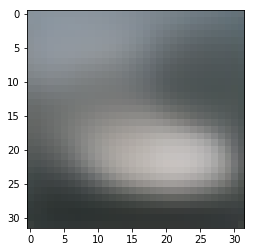

[Training Epoch: 15 	n_iter: 11965 	Loss: 116843.796875]


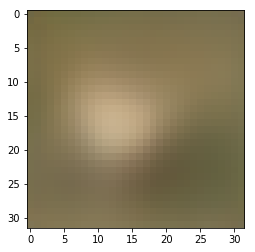

[Training Epoch: 15 	n_iter: 12015 	Loss: 117256.234375]


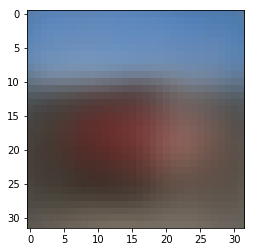

[Training Epoch: 15 	n_iter: 12065 	Loss: 120607.765625]


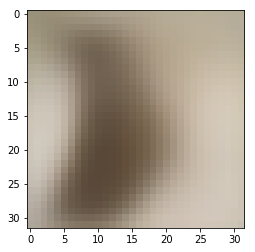

[Training Epoch: 15 	n_iter: 12115 	Loss: 116987.304688]


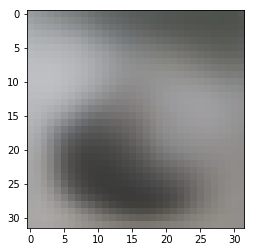

[Training Epoch: 15 	n_iter: 12165 	Loss: 118265.601562]


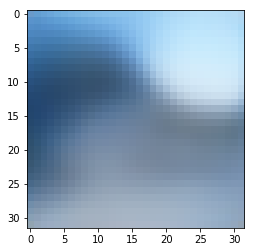

[Training Epoch: 15 	n_iter: 12215 	Loss: 119061.617188]


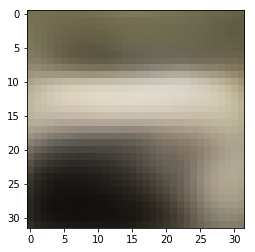

[Training Epoch: 15 	n_iter: 12265 	Loss: 112567.289062]


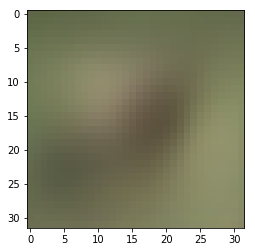

[Training Epoch: 15 	n_iter: 12315 	Loss: 118483.984375]


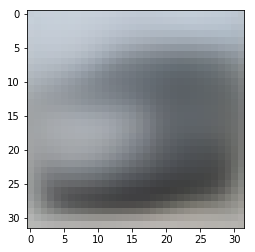

[Training Epoch: 15 	n_iter: 12365 	Loss: 115915.281250]


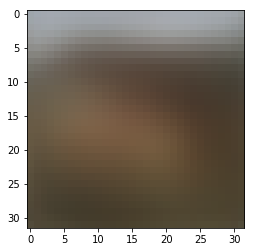

[Training Epoch: 15 	n_iter: 12415 	Loss: 117565.179688]


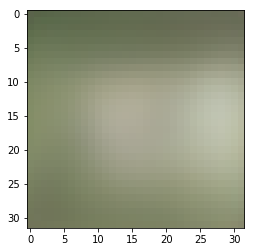

[Training Epoch: 15 	n_iter: 12465 	Loss: 118284.085938]


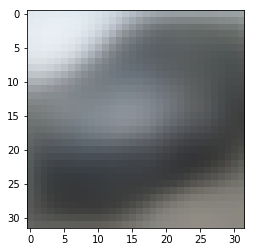

[Training Epoch: 16 	n_iter: 12496 	Loss: 116610.882812]


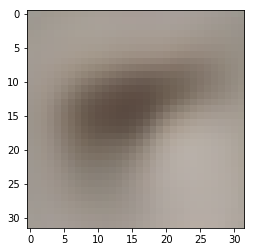

[Training Epoch: 16 	n_iter: 12546 	Loss: 118324.546875]


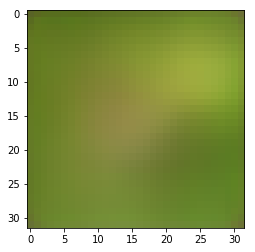

[Training Epoch: 16 	n_iter: 12596 	Loss: 118538.289062]


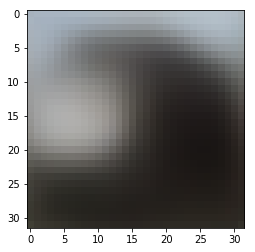

[Training Epoch: 16 	n_iter: 12646 	Loss: 118378.515625]


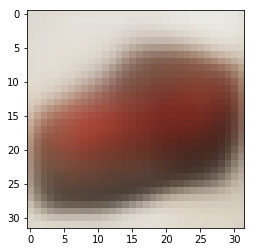

[Training Epoch: 16 	n_iter: 12696 	Loss: 121813.492188]


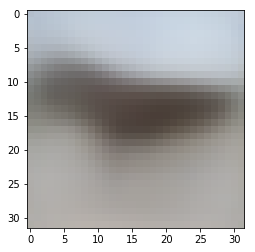

[Training Epoch: 16 	n_iter: 12746 	Loss: 118187.695312]


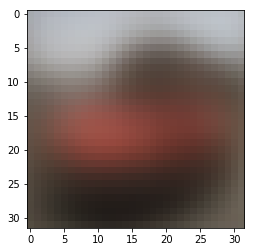

[Training Epoch: 16 	n_iter: 12796 	Loss: 120391.726562]


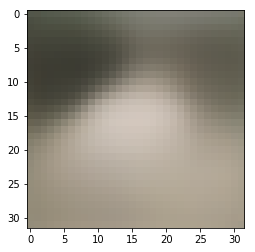

[Training Epoch: 16 	n_iter: 12846 	Loss: 116555.062500]


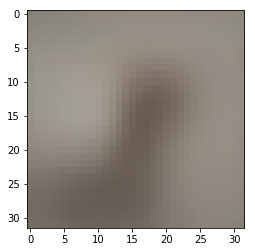

[Training Epoch: 16 	n_iter: 12896 	Loss: 119467.453125]


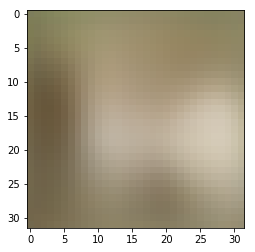

[Training Epoch: 16 	n_iter: 12946 	Loss: 118589.289062]


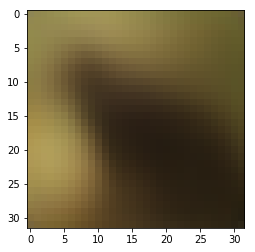

[Training Epoch: 16 	n_iter: 12996 	Loss: 117700.140625]


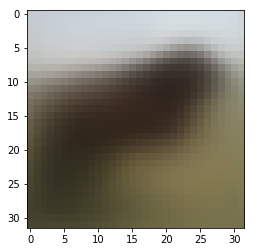

[Training Epoch: 16 	n_iter: 13046 	Loss: 119917.210938]


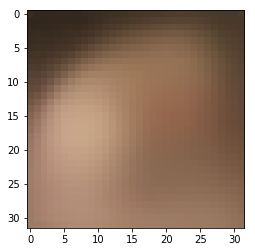

[Training Epoch: 16 	n_iter: 13096 	Loss: 117394.437500]


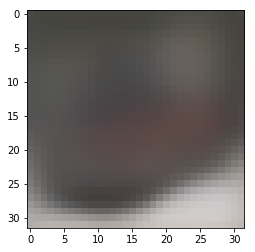

[Training Epoch: 16 	n_iter: 13146 	Loss: 120079.773438]


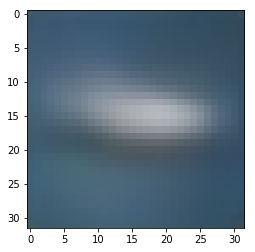

[Training Epoch: 16 	n_iter: 13196 	Loss: 116376.906250]


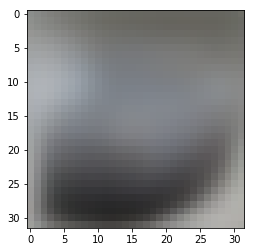

[Training Epoch: 16 	n_iter: 13246 	Loss: 114360.656250]


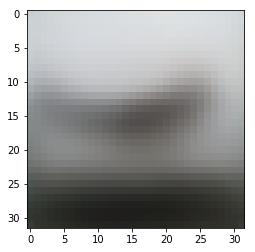

[Training Epoch: 17 	n_iter: 13277 	Loss: 115844.953125]


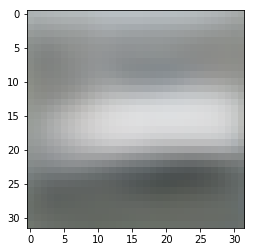

[Training Epoch: 17 	n_iter: 13327 	Loss: 116322.234375]


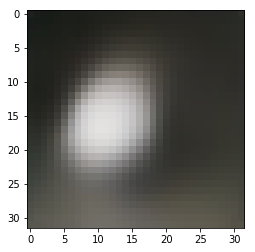

[Training Epoch: 17 	n_iter: 13377 	Loss: 119887.976562]


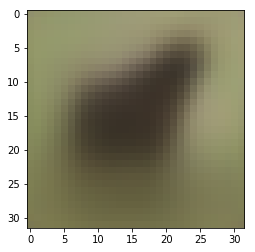

[Training Epoch: 17 	n_iter: 13427 	Loss: 116370.000000]


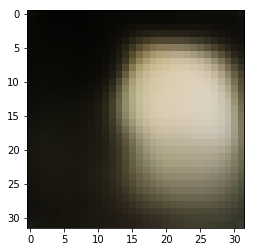

[Training Epoch: 17 	n_iter: 13477 	Loss: 120004.062500]


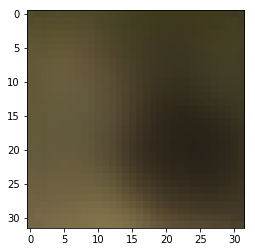

[Training Epoch: 17 	n_iter: 13527 	Loss: 117700.304688]


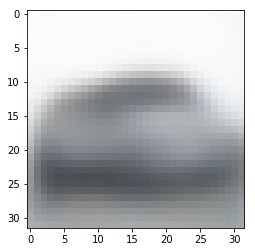

[Training Epoch: 17 	n_iter: 13577 	Loss: 116996.226562]


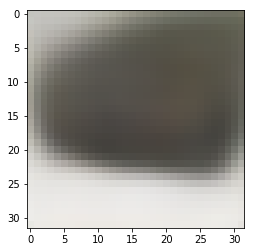

[Training Epoch: 17 	n_iter: 13627 	Loss: 120585.859375]


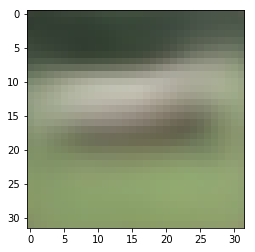

[Training Epoch: 17 	n_iter: 13677 	Loss: 118762.078125]


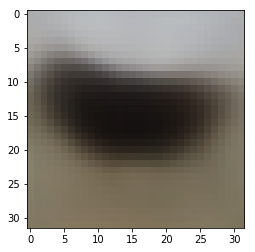

[Training Epoch: 17 	n_iter: 13727 	Loss: 120161.531250]


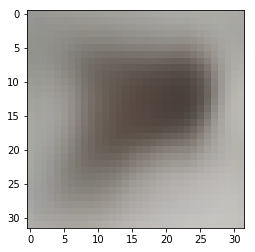

[Training Epoch: 17 	n_iter: 13777 	Loss: 113627.476562]


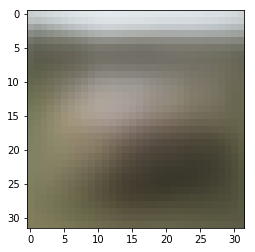

[Training Epoch: 17 	n_iter: 13827 	Loss: 118391.289062]


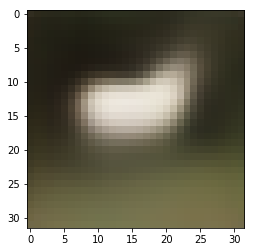

[Training Epoch: 17 	n_iter: 13877 	Loss: 119416.781250]


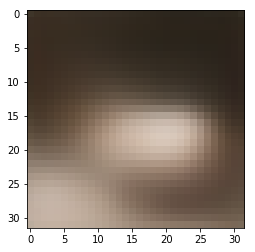

[Training Epoch: 17 	n_iter: 13927 	Loss: 119897.320312]


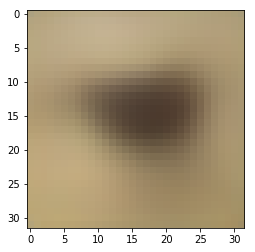

[Training Epoch: 17 	n_iter: 13977 	Loss: 116048.859375]


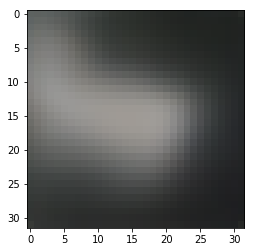

[Training Epoch: 17 	n_iter: 14027 	Loss: 115855.281250]


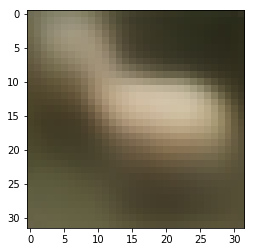

[Training Epoch: 18 	n_iter: 14058 	Loss: 121330.203125]


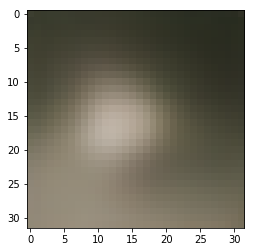

[Training Epoch: 18 	n_iter: 14108 	Loss: 118066.976562]


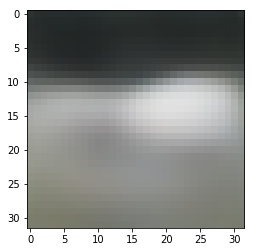

[Training Epoch: 18 	n_iter: 14158 	Loss: 116369.992188]


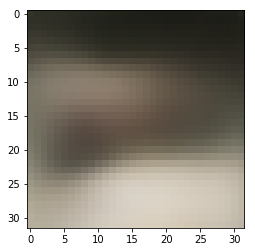

[Training Epoch: 18 	n_iter: 14208 	Loss: 117983.492188]


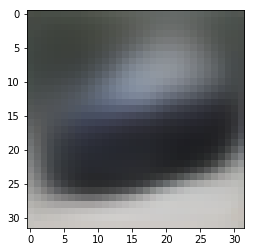

[Training Epoch: 18 	n_iter: 14258 	Loss: 118139.320312]


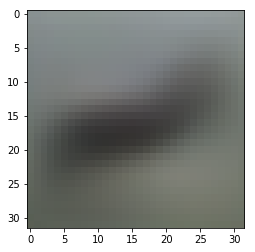

[Training Epoch: 18 	n_iter: 14308 	Loss: 118220.539062]


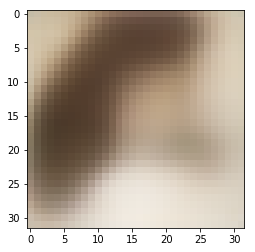

[Training Epoch: 18 	n_iter: 14358 	Loss: 119684.664062]


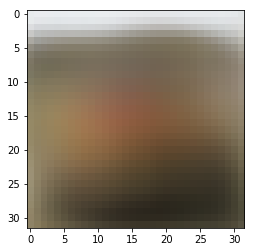

[Training Epoch: 18 	n_iter: 14408 	Loss: 116287.968750]


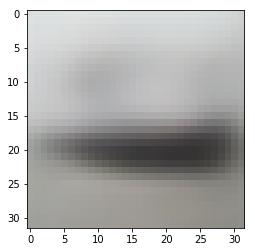

[Training Epoch: 18 	n_iter: 14458 	Loss: 117901.453125]


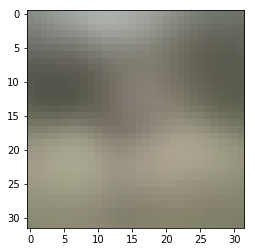

[Training Epoch: 18 	n_iter: 14508 	Loss: 117051.015625]


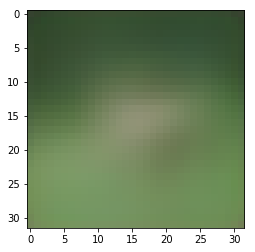

[Training Epoch: 18 	n_iter: 14558 	Loss: 118713.765625]


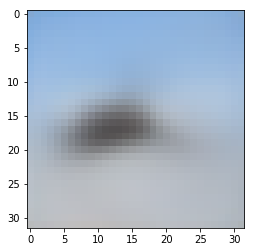

[Training Epoch: 18 	n_iter: 14608 	Loss: 115956.140625]


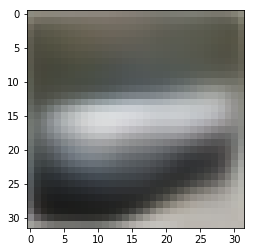

[Training Epoch: 18 	n_iter: 14658 	Loss: 119449.820312]


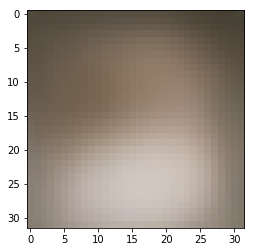

[Training Epoch: 18 	n_iter: 14708 	Loss: 119288.507812]


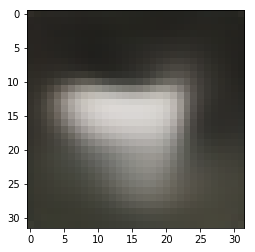

[Training Epoch: 18 	n_iter: 14758 	Loss: 117276.835938]


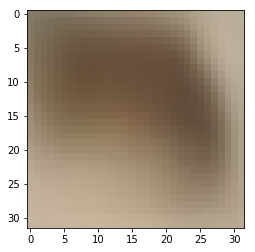

[Training Epoch: 18 	n_iter: 14808 	Loss: 118026.070312]


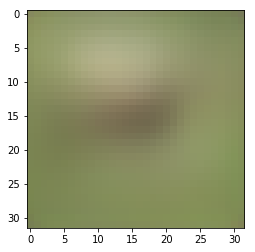

[Training Epoch: 19 	n_iter: 14839 	Loss: 117702.742188]


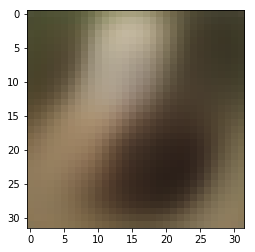

[Training Epoch: 19 	n_iter: 14889 	Loss: 118495.500000]


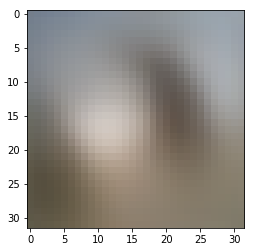

[Training Epoch: 19 	n_iter: 14939 	Loss: 118901.859375]


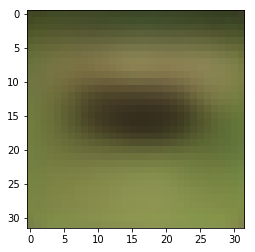

[Training Epoch: 19 	n_iter: 14989 	Loss: 119576.492188]


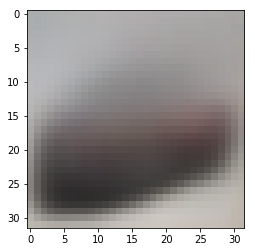

[Training Epoch: 19 	n_iter: 15039 	Loss: 121395.523438]


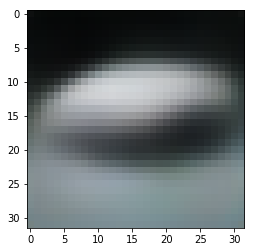

[Training Epoch: 19 	n_iter: 15089 	Loss: 118071.140625]


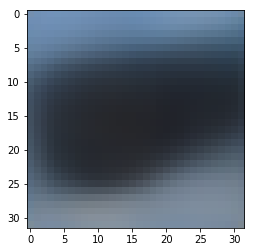

[Training Epoch: 19 	n_iter: 15139 	Loss: 117941.835938]


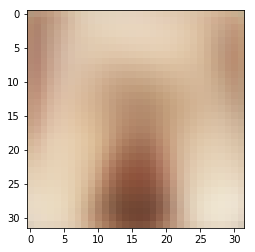

[Training Epoch: 19 	n_iter: 15189 	Loss: 115974.281250]


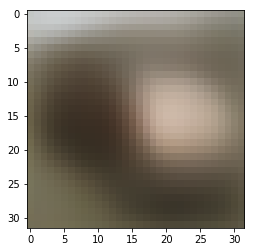

[Training Epoch: 19 	n_iter: 15239 	Loss: 118921.585938]


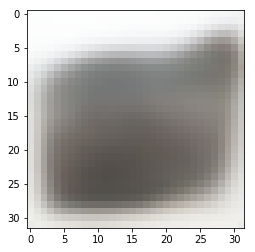

[Training Epoch: 19 	n_iter: 15289 	Loss: 117571.085938]


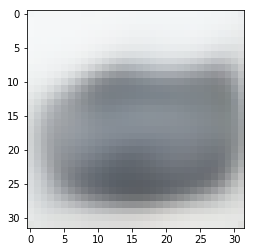

[Training Epoch: 19 	n_iter: 15339 	Loss: 118734.359375]


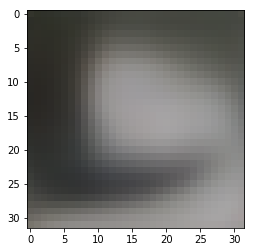

[Training Epoch: 19 	n_iter: 15389 	Loss: 121515.625000]


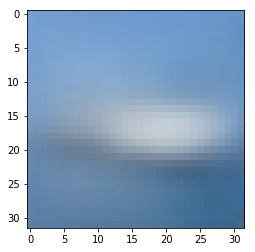

[Training Epoch: 19 	n_iter: 15439 	Loss: 117280.734375]


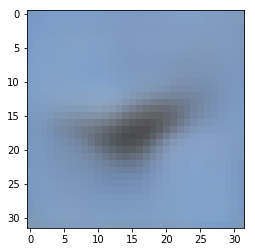

[Training Epoch: 19 	n_iter: 15489 	Loss: 113763.304688]


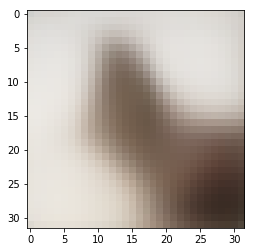

[Training Epoch: 19 	n_iter: 15539 	Loss: 115869.992188]


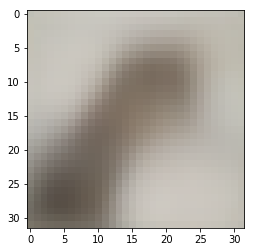

[Training Epoch: 19 	n_iter: 15589 	Loss: 120483.468750]


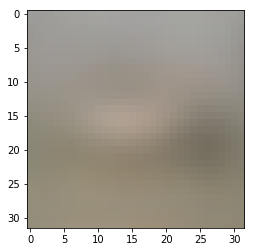

In [143]:
#writer=SummaryWriter()

try:
    model = torch.load('./model/dVAE.pkl')
    print("\n================== Model Restored ==================\n")
except:
    print("\n============== No Model to be Restored ==============\n")
    pass

for i in range(num_epoch):
    for batch_idx,[image,_] in enumerate(train_loader):
        n_iter = (i*len(train_loader))+batch_idx
        
        if use_gpu:
            x=Variable(image).cuda()
        else:
            x=Variable(image)
        # x: batchsize x 3 x 32 x 32
        optimizer.zero_grad()
        
        reconstructed_image=model(x)
        
        loss=loss_func(reconstructed_image,x,model.z_mu,model.z_logvar)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx%50==0:
            print('[Training Epoch: {} \tn_iter: {} \tLoss: {:.6f}]'.format(
                i, n_iter, loss.data[0]))
            plt.imshow(reconstructed_image.cpu().data[0].numpy().transpose(1,2,0), cmap='hsv')
            plt.show(block=True)
            
            
        if batch_idx%200==0:
            torch.save(model,'./model/dVAE_'+str(batch_idx)+'.pkl')
            torch.save(model,'./model/dVAE.pkl')
            
#        writer.add_scalar('loss',loss.data[0] / len(x),n_iter)
  

In [123]:
reconstructed_image.cpu().data[0].numpy().transpose(1,2,0)

array([[[ 0.50167495,  0.51882547,  0.50488049],
        [ 0.50362229,  0.52110022,  0.50821853],
        [ 0.50677085,  0.52629131,  0.5122872 ],
        ..., 
        [ 0.50487953,  0.52528012,  0.51094961],
        [ 0.50053352,  0.51937765,  0.50787246],
        [ 0.49801102,  0.51467299,  0.50054884]],

       [[ 0.50242889,  0.5182777 ,  0.50406826],
        [ 0.50056952,  0.51543373,  0.50166714],
        [ 0.50297159,  0.52127045,  0.50581604],
        ..., 
        [ 0.50049061,  0.51908678,  0.5037871 ],
        [ 0.49627137,  0.51254183,  0.50101703],
        [ 0.49686319,  0.51339757,  0.4998073 ]],

       [[ 0.50129682,  0.51576805,  0.4953188 ],
        [ 0.49827197,  0.51334023,  0.49408391],
        [ 0.50127959,  0.51948518,  0.50065577],
        ..., 
        [ 0.49968538,  0.51727796,  0.49878773],
        [ 0.49528018,  0.51164144,  0.4942739 ],
        [ 0.49547273,  0.51017439,  0.49070603]],

       ..., 
       [[ 0.49100497,  0.49029741,  0.44566473],
        

## Sample results

In [ ]:
example_z = Variable(torch.FloatTensor(8*8*z_dim).normal_(0,1).view(64,-1))

samples = model.decoder(example_z).data.numpy()
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(8, 8)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(32, 32,3).transpose(1,2,0), cmap='hsv')
fig.savefig("generated_images_by_{}epochs.png".format(num_epoch))